In [2]:
from ast import Index

import pandas as pd
import re
from pathlib import Path
import matplotlib.pyplot as plt
from sqlglot import column

bank_df = pd.read_csv('icea_bank.xlsx - bank_recon.csv')
cash_book = pd.read_csv('icea_cashbook.xlsx - cash_book_recon.csv')



In [3]:
## Filter out charges from bank
bank_df_ncba = bank_df[bank_df['is_charge'] == False]

## Drop duplicates
cash_book = cash_book.drop_duplicates()
bank_df_ncba = bank_df_ncba.drop_duplicates()


In [4]:
# Create the new columns in bank by combining the values from the specified columns
bank_df_ncba.loc[:, 'trx_id'] = bank_df_ncba[['ft_no', 'tt_no', 'aaa_no', 'md_no']].bfill(axis=1).iloc[:, 0]
bank_df_ncba.loc[:, 'trx_id2'] = bank_df_ncba[['charge_id', 'batch_no','bulk_trans_id','inhouse_cheque_no','cheque_no']].bfill(axis=1).iloc[:, 0]

bank_df_ncba

,index_bank,date,transaction_details_1,transaction_details_2,amount,trx_type,trans_type,trx_detail,period,ft_no,...,aaa_no,md_no,charge_id,batch_no,inhouse_cheque_no,cheque_no,bulk_trans_id,is_charge,trx_id,trx_id2
0,0,2023-11-01 00:00:00,Standing Order FT233054RNZQ,POLICY PREMIUM 029/VES/155738 EUNICE KAMBA MBU...,2206.00,credit,Standing Order,Standing Order FT233054RNZQ POLICY PREMIUM 029...,2023Q4,FT233054RNZQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,FT233054RNZQ,NaN
1,1,2023-11-01 00:00:00,Standing Order FT23305LCPC5,093715/093716/143362/171223 MARTIN KIMANI KANG...,8020.00,credit,Standing Order,Standing Order FT23305LCPC5 093715/093716/1433...,2023Q4,FT23305LCPC5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,FT23305LCPC5,NaN
2,2,2023-11-01 00:00:00,Standing Order FT23305RQKBY,JK Policy no. 027/EAW/232465 JANE JEMATIA KIPL...,64000.00,credit,Standing Order,Standing Order FT23305RQKBY JK Policy no. 027/...,2023Q4,FT23305RQKBY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,FT23305RQKBY,NaN
3,3,2023-11-01 00:00:00,Standing Order FT23305K8ZVX,025/NCBAEDU/267594 PURITY GAKII,10025.00,credit,Standing Order,Standing Order FT23305K8ZVX 025/NCBAEDU/267594...,2023Q4,FT23305K8ZVX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,FT23305K8ZVX,NaN
4,4,2023-11-01 00:00:00,Standing Order FT2330502XLT,POLICY NO: 029/EAW/208751 INVESTMENT POLICY MA...,2005.00,credit,Standing Order,Standing Order FT2330502XLT POLICY NO: 029/EAW...,2023Q4,FT2330502XLT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,FT2330502XLT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3165,3165,2023-11-30 00:00:00,Internal Transfer FT23334XKMS5,DIRECT DEBIT POLICY 027/EAW/264613 JENNIFER KA...,16529.00,credit,Internal Transfer,Internal Transfer FT23334XKMS5 DIRECT DEBIT PO...,2023Q4,FT23334XKMS5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,FT23334XKMS5,NaN
3166,3166,2023-11-30 00:00:00,Local Cheque Deposit,CHQ-000548 ROY FT233342CX8X,35000.00,credit,Local Cheque Deposit,Local Cheque Deposit CHQ-000548 ROY FT233342CX8X,2023Q4,FT233342CX8X,...,NaN,NaN,NaN,NaN,NaN,548.0,NaN,False,FT233342CX8X,548.0
3167,3167,2023-11-30 00:00:00,Local Cheque Deposit,CHQ-000336 REBECCA FT233343SV7C,14117.00,credit,Local Cheque Deposit,Local Cheque Deposit CHQ-000336 REBECCA FT2333...,2023Q4,FT233343SV7C,...,NaN,NaN,NaN,NaN,NaN,336.0,NaN,False,FT233343SV7C,336.0
3168,3168,2023-11-30 00:00:00,Local Cheque Deposit,CHQ-000645 PRESTIGE FT23334T4VS8,10000.00,credit,Local Cheque Deposit,Local Cheque Deposit CHQ-000645 PRESTIGE FT233...,2023Q4,FT23334T4VS8,...,NaN,NaN,NaN,NaN,NaN,645.0,NaN,False,FT23334T4VS8,645.0


In [5]:
## Extract policy no from bank
def extract_and_remove_patterns(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
    # Define the patterns to be extracted
    patterns = [
        r"\d{3}/[A-Za-z]{3}/\d+",  # e.g., "123/ABC/456"
        r"\d{3}/[A-Za-z]{3}\d+",   # e.g., "123/ABC456"
        r"\d{3}[A-Za-z]{3}/\d+",   # e.g., "123ABC/456"
        r"\d{3}[A-Za-z]{3}\d+",    # e.g., "123ABC456"
        r"\d{3}[A-Za-z]{3} \d+",   # e.g., "123ABC 456"
        r"\d{3} [A-Za-z]{3}\d+",   # e.g., "123 ABC456"
        r"\d{3} [A-Za-z]{3} \d+",  # e.g., "123 ABC 456"
        r"\d{3}/'NCBAEDU/\d+" ,   # e.g., "123/'NCBAEDU'/456"
        r"\d{3}/NCBAEDU\d+",     # e.g., "123/'NCBAEDU'456"
        r"\d{3}NCBAEDU\d+",      # e.g., "123'NCBAEDU'/456"
        r"\d{3} NCBAEDU \d+"    # e.g., "123 'NCBAEDU' 456"
        ]


      # Combine the patterns into a single regex with alternation
    combined_pattern = "|".join(patterns)

    # Function to extract the pattern and remove it from the original text
    def extract_pattern(text):
        match = re.search(combined_pattern, text, re.IGNORECASE)  # Case-insensitive search
        if match:
            extracted = match.group()
            cleaned_text = re.sub(combined_pattern, "", text, flags=re.IGNORECASE).strip()  # Case-insensitive removal
            return extracted, cleaned_text
        return None, text

    # Apply the extraction and removal function
    df[['policy_no', column_name]] = df[column_name].apply(
        lambda x: pd.Series(extract_pattern(str(x)))
    )

    return df

bank_df_ncba = extract_and_remove_patterns(bank_df_ncba, 'transaction_details_2')


In [6]:
bank_df_ncba.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2361 entries, 0 to 3171
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   index_bank             2361 non-null   int64  
 1   date                   2361 non-null   object 
 2   transaction_details_1  2361 non-null   object 
 3   transaction_details_2  2361 non-null   object 
 4   amount                 2361 non-null   float64
 5   trx_type               2361 non-null   object 
 6   trans_type             2361 non-null   object 
 7   trx_detail             2361 non-null   object 
 8   period                 2361 non-null   object 
 9   ft_no                  2172 non-null   object 
 10  tt_no                  121 non-null    object 
 11  aaa_no                 62 non-null     object 
 12  md_no                  6 non-null      object 
 13  charge_id              0 non-null      object 
 14  batch_no               185 non-null    object 
 15  inhouse_c

In [7]:
cash_book.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20887 entries, 0 to 20886
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index_cb                  20887 non-null  int64  
 1   entry_no                  20887 non-null  int64  
 2   posting_date              20887 non-null  object 
 3   amount                    20887 non-null  float64
 4   eft_file_name_1           20819 non-null  object 
 5   eft_file_name_2           20819 non-null  object 
 6   eft_file_name_3           20819 non-null  object 
 7   document_no               20887 non-null  object 
 8   policy_no                 19753 non-null  object 
 9   beneficiary_account_name  20377 non-null  object 
 10  description               20885 non-null  object 
 11  um_username               19753 non-null  object 
 12  bank_account_no           20887 non-null  object 
 13  trx_type                  20887 non-null  object 
dtypes: flo

### Exploratory analysis

In [8]:
from splink.exploratory import completeness_chart
from splink import DuckDBAPI
db_api = DuckDBAPI()
completeness_chart(bank_df_ncba, db_api=db_api)

alt.LayerChart(...)

In [9]:
completeness_chart(cash_book, db_api=db_api)

alt.LayerChart(...)

In [10]:
from splink.exploratory import profile_columns

#profile_columns(bank_df_ncba, db_api=DuckDBAPI(), top_n=10, bottom_n=5)

In [11]:
cash_book

,index_cb,entry_no,posting_date,amount,eft_file_name_1,eft_file_name_2,eft_file_name_3,document_no,policy_no,beneficiary_account_name,description,um_username,bank_account_no,trx_type
0,0,28533671,2023-11-01 00:00:00,-1500000.00,INS103331011123,INS103331011123,INS103331011123,FPV-INS2023005697,NaN,ADVANCE CARS KENYA LIMITED,KDN530F DENIS ODOYO,NaN,2-740-02-002,payment
1,1,28533673,2023-11-01 00:00:00,-45000.00,RK163LN22A,RK163LN22A,RK163LN22A,2023020025786,027/AEN/107082,KANGAU JAMES NJENGA,NIC HEAD OFFICE,USSDPOLICYLOANUSER,2-740-02-002,receipt
2,2,28533687,2023-11-01 00:00:00,-59182.20,INS103017011123,INS103017011123,INS103017011123,2023020025493,028/AEN/178027,ELIZABETH A AWITTY,NIC HEAD OFFICE,SNZIOKA,2-740-02-002,receipt
3,3,28533690,2023-11-01 00:00:00,-817909.94,INS103017011123,INS103017011123,INS103017011123,2023020025294,028/EAW/073607,THOMAS ODHIAMBO ABADE,NIC HEAD OFFICE,SNZIOKA,2-740-02-002,receipt
4,4,28533692,2023-11-01 00:00:00,-730680.88,INS103017011123,INS103017011123,INS103017011123,2023020025720,022/CEA/078232,JEREMIAH APALIA LOMARI,NIC HEAD OFFICE,SNZIOKA,2-740-02-002,receipt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20882,20882,29292347,2023-11-30 00:00:00,4040520.71,FT23333FLGN5,FT23333FLGN5,FT23333FLGN5,FR-INS2023001512,NaN,NaN,DA AMOUNTS IN AC 19 ( FT233331T30Y ETC),NaN,2-740-02-002,receipt
20883,20883,29292349,2023-11-30 00:00:00,118000.00,FT23328CVM3G,FT23328CVM3G,FT23328CVM3G,FR-INS2023001513,NaN,NaN,NOVEMBER INTERFUND TRANSFER,NaN,2-740-02-002,receipt
20884,20884,29292375,2023-11-30 00:00:00,8518859.20,FT23326HHBP1,FT23326HHBP1,FT23326HHBP1,FR-INS2023001515,NaN,NaN,NOVEMBER INTERFUND TRANSFER,NaN,2-740-02-002,receipt
20885,20885,29292376,2023-11-30 00:00:00,-4900964.00,INS102613151223,INS102613151223,INS102613151223,FPV-INS2023006211,NaN,SAWA SACCO LTD,Nov 2023 sacco deductions,NaN,2-740-02-002,payment


In [12]:
from splink.exploratory import profile_columns

#profile_columns(cash_book, db_api=DuckDBAPI(), top_n=10, bottom_n=5)

In [90]:
# sort index
cash_book = cash_book.rename(columns={"index_cb":"unique_id"})
bank_df_ncba = bank_df_ncba.rename(columns={"index_bank":"unique_id"})

bank_df_ncba.columns

Index(['unique_id', 'date', 'amount', 'trx_type', 'eft1', 'eft2', 'policy_no'], dtype='object')

In [16]:
cash_book

,unique_id,entry_no,posting_date,amount,eft_file_name_1,eft_file_name_2,eft_file_name_3,document_no,policy_no,beneficiary_account_name,description,um_username,bank_account_no,trx_type
0,0,28533671,2023-11-01 00:00:00,-1500000.00,INS103331011123,INS103331011123,INS103331011123,FPV-INS2023005697,NaN,ADVANCE CARS KENYA LIMITED,KDN530F DENIS ODOYO,NaN,2-740-02-002,payment
1,1,28533673,2023-11-01 00:00:00,-45000.00,RK163LN22A,RK163LN22A,RK163LN22A,2023020025786,027/AEN/107082,KANGAU JAMES NJENGA,NIC HEAD OFFICE,USSDPOLICYLOANUSER,2-740-02-002,receipt
2,2,28533687,2023-11-01 00:00:00,-59182.20,INS103017011123,INS103017011123,INS103017011123,2023020025493,028/AEN/178027,ELIZABETH A AWITTY,NIC HEAD OFFICE,SNZIOKA,2-740-02-002,receipt
3,3,28533690,2023-11-01 00:00:00,-817909.94,INS103017011123,INS103017011123,INS103017011123,2023020025294,028/EAW/073607,THOMAS ODHIAMBO ABADE,NIC HEAD OFFICE,SNZIOKA,2-740-02-002,receipt
4,4,28533692,2023-11-01 00:00:00,-730680.88,INS103017011123,INS103017011123,INS103017011123,2023020025720,022/CEA/078232,JEREMIAH APALIA LOMARI,NIC HEAD OFFICE,SNZIOKA,2-740-02-002,receipt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20882,20882,29292347,2023-11-30 00:00:00,4040520.71,FT23333FLGN5,FT23333FLGN5,FT23333FLGN5,FR-INS2023001512,NaN,NaN,DA AMOUNTS IN AC 19 ( FT233331T30Y ETC),NaN,2-740-02-002,receipt
20883,20883,29292349,2023-11-30 00:00:00,118000.00,FT23328CVM3G,FT23328CVM3G,FT23328CVM3G,FR-INS2023001513,NaN,NaN,NOVEMBER INTERFUND TRANSFER,NaN,2-740-02-002,receipt
20884,20884,29292375,2023-11-30 00:00:00,8518859.20,FT23326HHBP1,FT23326HHBP1,FT23326HHBP1,FR-INS2023001515,NaN,NaN,NOVEMBER INTERFUND TRANSFER,NaN,2-740-02-002,receipt
20885,20885,29292376,2023-11-30 00:00:00,-4900964.00,INS102613151223,INS102613151223,INS102613151223,FPV-INS2023006211,NaN,SAWA SACCO LTD,Nov 2023 sacco deductions,NaN,2-740-02-002,payment


### Blocking

In [17]:
from splink import DuckDBAPI, block_on
from splink.blocking_analysis import n_largest_blocks

from splink.blocking_analysis import count_comparisons_from_blocking_rule
db_api = DuckDBAPI()

from splink.blocking_analysis import (
    cumulative_comparisons_to_be_scored_from_blocking_rules_chart,
)

## Rename cols to common names
cash_book = cash_book.rename(columns={"posting_date":"date"})
cash_book = cash_book.rename(columns={"eft_file_name_1":"eft1","eft_file_name_2":"eft2"})
bank_df_ncba = bank_df_ncba.rename(columns={"trx_id":"eft1","trx_id2":"eft2",})


columns_to_keep = ['unique_id','date','amount','eft1','eft2','policy_no','trx_type']

# Drop all columns except those in `columns_to_keep`
bank_df_ncba= bank_df_ncba.drop(columns=[col for col in bank_df_ncba.columns if col not in columns_to_keep])
cash_book= cash_book.drop(columns=[col for col in cash_book.columns if col not in columns_to_keep])



In [21]:

blocking_rules_for_analysis = [
    block_on("policy_no","date"),
    block_on("date"),
    block_on("eft1"),
    block_on("eft2"),
    block_on("policy_no"),
    block_on("trx_type"),
    block_on("amount")
    
]


cumulative_comparisons_to_be_scored_from_blocking_rules_chart(
    table_or_tables=[bank_df_ncba,cash_book],
    blocking_rules=blocking_rules_for_analysis,
    db_api=db_api,
    link_type="link_only",
    
)

alt.Chart(...)

In [30]:
from splink.blocking_analysis import count_comparisons_from_blocking_rule

db_api = DuckDBAPI()

br = block_on('date',"amount")

counts = count_comparisons_from_blocking_rule(
    table_or_tables=[bank_df_ncba,cash_book],
    blocking_rule=br,
    link_type="link_only",
    db_api=db_api,
)

counts

{'number_of_comparisons_generated_pre_filter_conditions': 10486,
 'number_of_comparisons_to_be_scored_post_filter_conditions': 10486,
 'filter_conditions_identified': '',
 'equi_join_conditions_identified': 'l."date" = r."date" AND l."amount" = r."amount"',
 'link_type_join_condition': 'where l."source_dataset" || \'-__-\' || l."unique_id" < r."source_dataset" || \'-__-\' || r."unique_id" and l."source_dataset" != r."source_dataset"'}

In [28]:
## worst offending 
from splink.blocking_analysis import n_largest_blocks

results = n_largest_blocks(table_or_tables=[bank_df_ncba,cash_book],
                           blocking_rule=block_on("date","policy_no"),
                           link_type="link_only",
                           db_api=db_api,
                           n_largest=10)
results.as_pandas_dataframe()

,key_0,key_1,count_l,count_r,block_count
0,2023-11-09 00:00:00,027/EAW/083083,2,2,4
1,2023-11-01 00:00:00,036/EAW/222526,1,2,2
2,2023-11-28 00:00:00,028/CEA/202590,1,2,2
3,2023-11-09 00:00:00,033/EAW/102867,1,2,2
4,2023-11-16 00:00:00,027/AEN/167685,1,2,2
5,2023-11-28 00:00:00,026/CEA/065639,1,2,2
6,2023-11-30 00:00:00,033/EAW/131941,1,2,2
7,2023-11-10 00:00:00,032/CEA/246475,1,2,2
8,2023-11-10 00:00:00,036/EAW/265631,1,2,2
9,2023-11-10 00:00:00,036/AEN/260166,1,2,2


In [61]:
from jellyfish import levenshtein_distance # Import levenshtein_distance

from splink.blocking_analysis import (
    cumulative_comparisons_to_be_scored_from_blocking_rules_chart,
)

blocking_rules_for_analysis = [
    block_on("policy_no","date"),
    block_on("eft1","trx_type"),
    block_on("trx_type","date"),
    block_on("date"),
    block_on("trx_type")
]


cumulative_comparisons_to_be_scored_from_blocking_rules_chart(
    table_or_tables=[bank_df_ncba,cash_book],
    blocking_rules=blocking_rules_for_analysis,
    db_api=db_api,
    link_type="link_only",
)

alt.Chart(...)

### Estimating model parameters

In [62]:
from splink import Linker, SettingsCreator, block_on, DuckDBAPI
import splink.comparison_library as cl

settings = SettingsCreator(
    unique_id_column_name="unique_id",
    link_type="link_only",
    comparisons=[
        cl.NameComparison("date").configure(term_frequency_adjustments=True),
        cl.NameComparison("policy_no").configure(term_frequency_adjustments=True),
        cl.NameComparison("eft1"),
        cl.NameComparison("eft2"),
        cl.NameComparison("trx_type").configure(term_frequency_adjustments=True),
        cl.ExactMatch("amount")  
    ],
    retain_intermediate_calculation_columns=True,
)
linker = Linker([bank_df_ncba,cash_book],settings,db_api=DuckDBAPI())

In [63]:
## estimate records match
deterministic_rules = [
    block_on("policy_no"),
    block_on("trx_type"),
    block_on("date","eft1"),
]
linker.training.estimate_probability_two_random_records_match(deterministic_rules, recall=0.7)

Probability two random records match is estimated to be  0.00017.
This means that amongst all possible pairwise record comparisons, one in 5,887.76 are expected to match.  With 49,314,207 total possible comparisons, we expect a total of around 8,375.71 matching pairs


In [64]:
## estimate u probabilities
linker.training.estimate_u_using_random_sampling(max_pairs=1e8)


----- Estimating u probabilities using random sampling -----


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

u probability not trained for date - Jaro-Winkler distance of date >= 0.88 (comparison vector value: 2). This usually means the comparison level was never observed in the training data.
u probability not trained for date - Jaro-Winkler distance of date >= 0.7 (comparison vector value: 1). This usually means the comparison level was never observed in the training data.
u probability not trained for date - All other comparisons (comparison vector value: 0). This usually means the comparison level was never observed in the training data.
u probability not trained for trx_type - Exact match on trx_type (comparison vector value: 4). This usually means the comparison level was never observed in the training data.
u probability not trained for trx_type - Jaro-Winkler distance of trx_type >= 0.92 (comparison vector value: 3). This usually means the comparison level was never observed in the training data.
u probability not trained for trx_type - Jaro-Winkler distance of trx_type >= 0.88 (compa

In [65]:
## estimate m probabilities

# first pass
training_block_rule = block_on("policy_no","date")
training_session_dob =(
    linker.training.estimate_parameters_using_expectation_maximisation(training_block_rule)
)



----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
(l."policy_no" = r."policy_no") AND (l."date" = r."date")

Parameter estimates will be made for the following comparison(s):
    - eft1
    - eft2
    - trx_type
    - amount

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - date
    - policy_no

Level Exact match on eft2 on comparison eft2 not observed in dataset, unable to train m value

Level Jaro-Winkler distance of eft2 >= 0.88 on comparison eft2 not observed in dataset, unable to train m value

Level Exact match on trx_type on comparison trx_type not observed in dataset, unable to train m value

Level Jaro-Winkler distance of trx_type >= 0.92 on comparison trx_type not observed in dataset, unable to train m value

Level Jaro-Winkler distance of trx_type >= 0.88 on comparison trx_type not observed in dataset, unable to train m value

Iteration 1: Largest change i

# second pass
training_block_rule = block_on("trx_type","amount")
training_session_fname_sname =(
    linker.training.estimate_parameters_using_expectation_maximisation(training_block_rule)
)

In [66]:
linker.visualisations.match_weights_chart()

alt.VConcatChart(...)

In [67]:
linker.visualisations.m_u_parameters_chart()

alt.HConcatChart(...)

In [68]:
linker.visualisations.parameter_estimate_comparisons_chart()

alt.Chart(...)

In [69]:
#detecting unlinkable records
linker.evaluation.unlinkables_chart()

alt.LayerChart(...)

In [74]:
df_predictions = linker.inference.predict(threshold_match_probability=0.5)
df_predictions.as_pandas_dataframe(limit=5)

# threshold = 0.5 to ensure match weight is > 0

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Blocking time: 8.75 seconds


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Predict time: 183.09 seconds

 -- WARNING --
You have called predict(), but there are some parameter estimates which have neither been estimated or specified in your settings dictionary.  To produce predictions the following untrained trained parameters will use default values.
Comparison: 'date':
    m values not fully trained
Comparison: 'date':
    u values not fully trained
Comparison: 'policy_no':
    m values not fully trained
Comparison: 'eft2':
    m values not fully trained
Comparison: 'trx_type':
    m values not fully trained
Comparison: 'trx_type':
    u values not fully trained


,match_weight,match_probability,source_dataset_l,source_dataset_r,unique_id_l,unique_id_r,date_l,date_r,gamma_date,tf_date_l,...,trx_type_r,gamma_trx_type,tf_trx_type_l,tf_trx_type_r,bf_trx_type,bf_tf_adj_trx_type,amount_l,amount_r,gamma_amount,bf_amount
0,11.062324,0.999533,__splink__input_table_0,__splink__input_table_1,67,236,2023-11-01 00:00:00,2023-11-01 00:00:00,4,0.224751,...,receipt,1,0.070286,0.860633,1.484014,1.0,3008.0,3008.0,1,205.042673
1,13.089568,0.999885,__splink__input_table_0,__splink__input_table_1,125,252,2023-11-01 00:00:00,2023-11-01 00:00:00,4,0.224751,...,receipt,1,0.070286,0.860633,1.484014,1.0,348000.0,348000.0,1,205.042673
2,11.062324,0.999533,__splink__input_table_0,__splink__input_table_1,32,260,2023-11-01 00:00:00,2023-11-01 00:00:00,4,0.224751,...,receipt,1,0.070286,0.860633,1.484014,1.0,5500.0,5500.0,1,205.042673
3,13.378874,0.999906,__splink__input_table_0,__splink__input_table_1,29,165,2023-11-01 00:00:00,2023-11-01 00:00:00,4,0.224751,...,receipt,1,0.070286,0.860633,1.484014,1.0,5546.0,5546.0,1,205.042673
4,23.596772,1.000000,__splink__input_table_0,__splink__input_table_1,39,3953,2023-11-01 00:00:00,2023-11-01 00:00:00,4,0.224751,...,receipt,1,0.070286,0.860633,1.484014,1.0,50125.0,50125.0,1,205.042673


In [75]:
df_predictions.as_pandas_dataframe()


,match_weight,match_probability,source_dataset_l,source_dataset_r,unique_id_l,unique_id_r,date_l,date_r,gamma_date,tf_date_l,...,trx_type_r,gamma_trx_type,tf_trx_type_l,tf_trx_type_r,bf_trx_type,bf_tf_adj_trx_type,amount_l,amount_r,gamma_amount,bf_amount
0,11.062324,0.999533,__splink__input_table_0,__splink__input_table_1,67,236,2023-11-01 00:00:00,2023-11-01 00:00:00,4,0.224751,...,receipt,1,0.070286,0.860633,1.484014,1.0,3008.00,3008.00,1,205.042673
1,13.089568,0.999885,__splink__input_table_0,__splink__input_table_1,125,252,2023-11-01 00:00:00,2023-11-01 00:00:00,4,0.224751,...,receipt,1,0.070286,0.860633,1.484014,1.0,348000.00,348000.00,1,205.042673
2,11.062324,0.999533,__splink__input_table_0,__splink__input_table_1,32,260,2023-11-01 00:00:00,2023-11-01 00:00:00,4,0.224751,...,receipt,1,0.070286,0.860633,1.484014,1.0,5500.00,5500.00,1,205.042673
3,13.378874,0.999906,__splink__input_table_0,__splink__input_table_1,29,165,2023-11-01 00:00:00,2023-11-01 00:00:00,4,0.224751,...,receipt,1,0.070286,0.860633,1.484014,1.0,5546.00,5546.00,1,205.042673
4,23.596772,1.000000,__splink__input_table_0,__splink__input_table_1,39,3953,2023-11-01 00:00:00,2023-11-01 00:00:00,4,0.224751,...,receipt,1,0.070286,0.860633,1.484014,1.0,50125.00,50125.00,1,205.042673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1364,2.724540,0.868585,__splink__input_table_0,__splink__input_table_1,52,12422,2023-11-01 00:00:00,2023-11-20 00:00:00,3,0.224751,...,receipt,1,0.070286,0.860633,1.484014,1.0,468612.16,468612.16,1,205.042673
1365,2.724540,0.868585,__splink__input_table_0,__splink__input_table_1,53,12423,2023-11-01 00:00:00,2023-11-20 00:00:00,3,0.224751,...,receipt,1,0.070286,0.860633,1.484014,1.0,184687.20,184687.20,1,205.042673
1366,2.724540,0.868585,__splink__input_table_0,__splink__input_table_1,1441,12427,2023-11-14 00:00:00,2023-11-20 00:00:00,3,0.019098,...,receipt,1,0.070286,0.860633,1.484014,1.0,1688998.00,1688998.00,1,205.042673
1367,4.000110,0.941181,__splink__input_table_0,__splink__input_table_1,2864,17772,2023-11-29 00:00:00,2023-11-29 00:00:00,4,0.027916,...,receipt,1,0.070286,0.860633,1.484014,1.0,107000.00,22000.00,0,0.093505


In [76]:
# CLUSTERING
clusters = linker.clustering.cluster_pairwise_predictions_at_threshold(
    df_predictions, threshold_match_probability=0.5
)
clusters.as_pandas_dataframe(limit=10)

Completed iteration 1, root rows count 8
Completed iteration 2, root rows count 3
Completed iteration 3, root rows count 2
Completed iteration 4, root rows count 0


,cluster_id,source_dataset,unique_id,date,amount,trx_type,eft1,eft2,policy_no,__splink_salt,tf_policy_no,tf_date,tf_trx_type,tf_eft1,tf_eft2
0,__splink__input_table_0-__-270,__splink__input_table_0,281,2023-11-03 00:00:00,1.002500e+04,credit,FT23307H68P2,5319.0,None,0.717260,NaN,0.032390,0.070286,0.000043,0.000046
1,__splink__input_table_0-__-686,__splink__input_table_1,8393,2023-11-07 00:00:00,5.012500e+04,receipt,002923,002923,036/EAW/220449,0.045269,0.000096,0.018711,0.860633,0.000043,0.000046
2,__splink__input_table_0-__-1788,__splink__input_table_0,1789,2023-11-17 00:00:00,2.630137e+06,credit,AAACT23321DCNY4G4G,None,None,0.010103,NaN,0.016905,0.070286,0.000129,NaN
3,__splink__input_table_0-__-2347,__splink__input_table_0,2375,2023-11-24 00:00:00,3.008000e+03,credit,FT2332820T9J,None,036/EAW/208903,0.734448,0.000096,0.021937,0.070286,0.000086,NaN
4,__splink__input_table_0-__-1162,__splink__input_table_0,1166,2023-11-10 00:00:00,2.053600e+04,credit,FT233147JNK9,None,029/CEA/165633,0.759453,0.000096,0.049123,0.070286,0.000086,NaN
5,__splink__input_table_0-__-2391,__splink__input_table_0,2396,2023-11-24 00:00:00,3.008000e+03,credit,FT23328TVXB0,None,None,0.761074,NaN,0.021937,0.070286,0.000086,NaN
6,__splink__input_table_0-__-1025,__splink__input_table_1,9019,2023-11-09 00:00:00,3.029589e+08,receipt,AAACT2331317BD5ZRR,AAACT2331317BD5ZRR,None,0.140083,NaN,0.033078,0.860633,0.000129,0.000046
7,__splink__input_table_0-__-1027,__splink__input_table_1,9260,2023-11-09 00:00:00,6.007397e+08,receipt,AAACT233130WPNGX6V,AAACT233130WPNGX6V,None,0.317344,NaN,0.033078,0.860633,0.000129,0.000046
8,__splink__input_table_0-__-1788,__splink__input_table_1,12324,2023-11-17 00:00:00,2.026301e+08,receipt,AAACT23321DCNY4G4G,AAACT23321DCNY4G4G,None,0.281168,NaN,0.016905,0.860633,0.000129,0.000046
9,__splink__input_table_0-__-2614,__splink__input_table_1,14949,2023-11-27 00:00:00,5.057534e+07,receipt,AAACT2333120MKPVP5,AAACT2333120MKPVP5,None,0.125257,NaN,0.016216,0.860633,0.000129,0.000046


In [77]:
## Waterfall chart
records_to_view = df_predictions.as_record_dict(limit=5)
linker.visualisations.waterfall_chart(records_to_view, filter_nulls=False)


alt.LayerChart(...)

In [87]:
match_predictions = df_predictions.as_pandas_dataframe()
match_predictions.columns

Index(['match_weight', 'match_probability', 'source_dataset_l',
       'source_dataset_r', 'unique_id_l', 'unique_id_r', 'date_l', 'date_r',
       'gamma_date', 'tf_date_l', 'tf_date_r', 'bf_date', 'bf_tf_adj_date',
       'policy_no_l', 'policy_no_r', 'gamma_policy_no', 'tf_policy_no_l',
       'tf_policy_no_r', 'bf_policy_no', 'bf_tf_adj_policy_no', 'eft1_l',
       'eft1_r', 'gamma_eft1', 'tf_eft1_l', 'tf_eft1_r', 'bf_eft1',
       'bf_tf_adj_eft1', 'eft2_l', 'eft2_r', 'gamma_eft2', 'tf_eft2_l',
       'tf_eft2_r', 'bf_eft2', 'bf_tf_adj_eft2', 'trx_type_l', 'trx_type_r',
       'gamma_trx_type', 'tf_trx_type_l', 'tf_trx_type_r', 'bf_trx_type',
       'bf_tf_adj_trx_type', 'amount_l', 'amount_r', 'gamma_amount',
       'bf_amount'],
      dtype='object')

In [89]:
bank_df.columns

Index(['index_bank', 'date', 'transaction_details_1', 'transaction_details_2',
       'amount', 'trx_type', 'trans_type', 'trx_detail', 'period', 'ft_no',
       'tt_no', 'aaa_no', 'md_no', 'charge_id', 'batch_no',
       'inhouse_cheque_no', 'cheque_no', 'bulk_trans_id', 'is_charge'],
      dtype='object')

In [91]:
match_predictions=match_predictions[['match_weight', 'match_probability', 'source_dataset_l',
       'source_dataset_r', 'unique_id_l', 'unique_id_r', 'date_l', 'date_r',
       'gamma_date', 'tf_date_l', 'tf_date_r', 'bf_date', 'bf_tf_adj_date',
       'policy_no_l', 'policy_no_r', 'gamma_policy_no', 'tf_policy_no_l',
       'tf_policy_no_r', 'bf_policy_no', 'bf_tf_adj_policy_no', 'eft1_l',
       'eft1_r', 'gamma_eft1', 'tf_eft1_l', 'tf_eft1_r', 'bf_eft1',
       'bf_tf_adj_eft1', 'eft2_l', 'eft2_r', 'gamma_eft2', 'tf_eft2_l',
       'tf_eft2_r', 'bf_eft2', 'bf_tf_adj_eft2', 'trx_type_l', 'trx_type_r',
       'gamma_trx_type', 'tf_trx_type_l', 'tf_trx_type_r', 'bf_trx_type',
       'bf_tf_adj_trx_type', 'amount_l', 'amount_r', 'gamma_amount',
       'bf_amount']]

In [95]:
bank_df_merged = bank_df.merge(match_predictions, how='left',left_on='index_bank',right_on='unique_id_l')
bank_df_merged.columns

Index(['index_bank', 'date', 'transaction_details_1', 'transaction_details_2',
       'amount', 'trx_type', 'trans_type', 'trx_detail', 'period', 'ft_no',
       'tt_no', 'aaa_no', 'md_no', 'charge_id', 'batch_no',
       'inhouse_cheque_no', 'cheque_no', 'bulk_trans_id', 'is_charge',
       'match_weight', 'match_probability', 'source_dataset_l',
       'source_dataset_r', 'unique_id_l', 'unique_id_r', 'date_l', 'date_r',
       'gamma_date', 'tf_date_l', 'tf_date_r', 'bf_date', 'bf_tf_adj_date',
       'policy_no_l', 'policy_no_r', 'gamma_policy_no', 'tf_policy_no_l',
       'tf_policy_no_r', 'bf_policy_no', 'bf_tf_adj_policy_no', 'eft1_l',
       'eft1_r', 'gamma_eft1', 'tf_eft1_l', 'tf_eft1_r', 'bf_eft1',
       'bf_tf_adj_eft1', 'eft2_l', 'eft2_r', 'gamma_eft2', 'tf_eft2_l',
       'tf_eft2_r', 'bf_eft2', 'bf_tf_adj_eft2', 'trx_type_l', 'trx_type_r',
       'gamma_trx_type', 'tf_trx_type_l', 'tf_trx_type_r', 'bf_trx_type',
       'bf_tf_adj_trx_type', 'amount_l', 'amount_r', 'gamm

In [97]:
# showing the matches where match weight is +ve
bank_df_merged['matched'] = bank_df_merged['match_weight'] > 0
bank_df_merged

,index_bank,date,transaction_details_1,transaction_details_2,amount,trx_type,trans_type,trx_detail,period,ft_no,...,gamma_trx_type,tf_trx_type_l,tf_trx_type_r,bf_trx_type,bf_tf_adj_trx_type,amount_l,amount_r,gamma_amount,bf_amount,matched
0,0,2023-11-01 00:00:00,Standing Order FT233054RNZQ,POLICY PREMIUM 029/VES/155738 EUNICE KAMBA MBU...,2206.00,credit,Standing Order,Standing Order FT233054RNZQ POLICY PREMIUM 029...,2023Q4,FT233054RNZQ,...,1.0,0.070286,0.860633,1.484014,1.0,2206.0,2206.0,1.0,205.042673,True
1,1,2023-11-01 00:00:00,Standing Order FT23305LCPC5,093715/093716/143362/171223 MARTIN KIMANI KANG...,8020.00,credit,Standing Order,Standing Order FT23305LCPC5 093715/093716/1433...,2023Q4,FT23305LCPC5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,2,2023-11-01 00:00:00,Standing Order FT23305RQKBY,JK Policy no. 027/EAW/232465 JANE JEMATIA KIPL...,64000.00,credit,Standing Order,Standing Order FT23305RQKBY JK Policy no. 027/...,2023Q4,FT23305RQKBY,...,1.0,0.070286,0.860633,1.484014,1.0,64000.0,64000.0,1.0,205.042673,True
3,3,2023-11-01 00:00:00,Standing Order FT23305K8ZVX,025/NCBAEDU/267594 PURITY GAKII,10025.00,credit,Standing Order,Standing Order FT23305K8ZVX 025/NCBAEDU/267594...,2023Q4,FT23305K8ZVX,...,1.0,0.070286,0.860633,1.484014,1.0,10025.0,10025.0,1.0,205.042673,True
4,4,2023-11-01 00:00:00,Standing Order FT2330502XLT,POLICY NO: 029/EAW/208751 INVESTMENT POLICY MA...,2005.00,credit,Standing Order,Standing Order FT2330502XLT POLICY NO: 029/EAW...,2023Q4,FT2330502XLT,...,1.0,0.070286,0.860633,1.484014,1.0,2005.0,2005.0,1.0,205.042673,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3429,3167,2023-11-30 00:00:00,Local Cheque Deposit,CHQ-000336 REBECCA FT233343SV7C,14117.00,credit,Local Cheque Deposit,Local Cheque Deposit CHQ-000336 REBECCA FT2333...,2023Q4,FT233343SV7C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3430,3168,2023-11-30 00:00:00,Local Cheque Deposit,CHQ-000645 PRESTIGE FT23334T4VS8,10000.00,credit,Local Cheque Deposit,Local Cheque Deposit CHQ-000645 PRESTIGE FT233...,2023Q4,FT23334T4VS8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3431,3169,2023-11-30 00:00:00,KE Excise Duty,Tax AAACT233349LBG3TZD,-204.00,debit,KE Excise Duty,KE Excise Duty Tax AAACT233349LBG3TZD,2023Q4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3432,3170,2023-11-30 00:00:00,Ledger Fee,Ledger Fees AAACT233349LBG3TZD,-1020.00,debit,Ledger Fee,Ledger Fee Ledger Fees AAACT233349LBG3TZD,2023Q4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


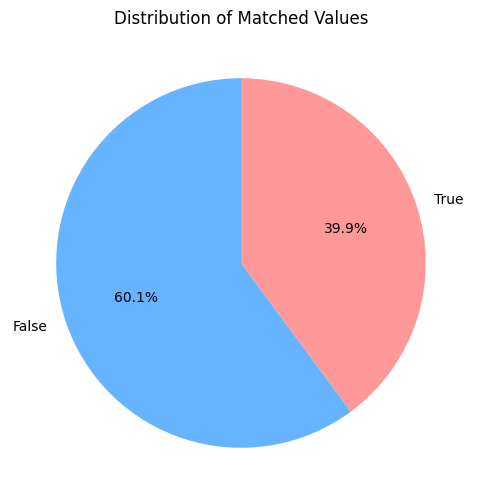

In [98]:
# PLOT
matched_counts = bank_df_merged['matched'].value_counts()

# Plotting a pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    matched_counts,
    labels=matched_counts.index.map({True: 'True', False: 'False'}),
    autopct='%1.1f%%',
    colors=['#66b3ff','#ff9999'],
    startangle=90
)
plt.title('Distribution of Matched Values')
plt.show()